In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Read the Excel file
excel_data = pd.ExcelFile("DS_task.xlsx")
#print(excel_data.sheet_names)
# Load data
df = excel_data.parse(sheet_name="STR_sample_data")  
#print(df.head())

(99848, 14)


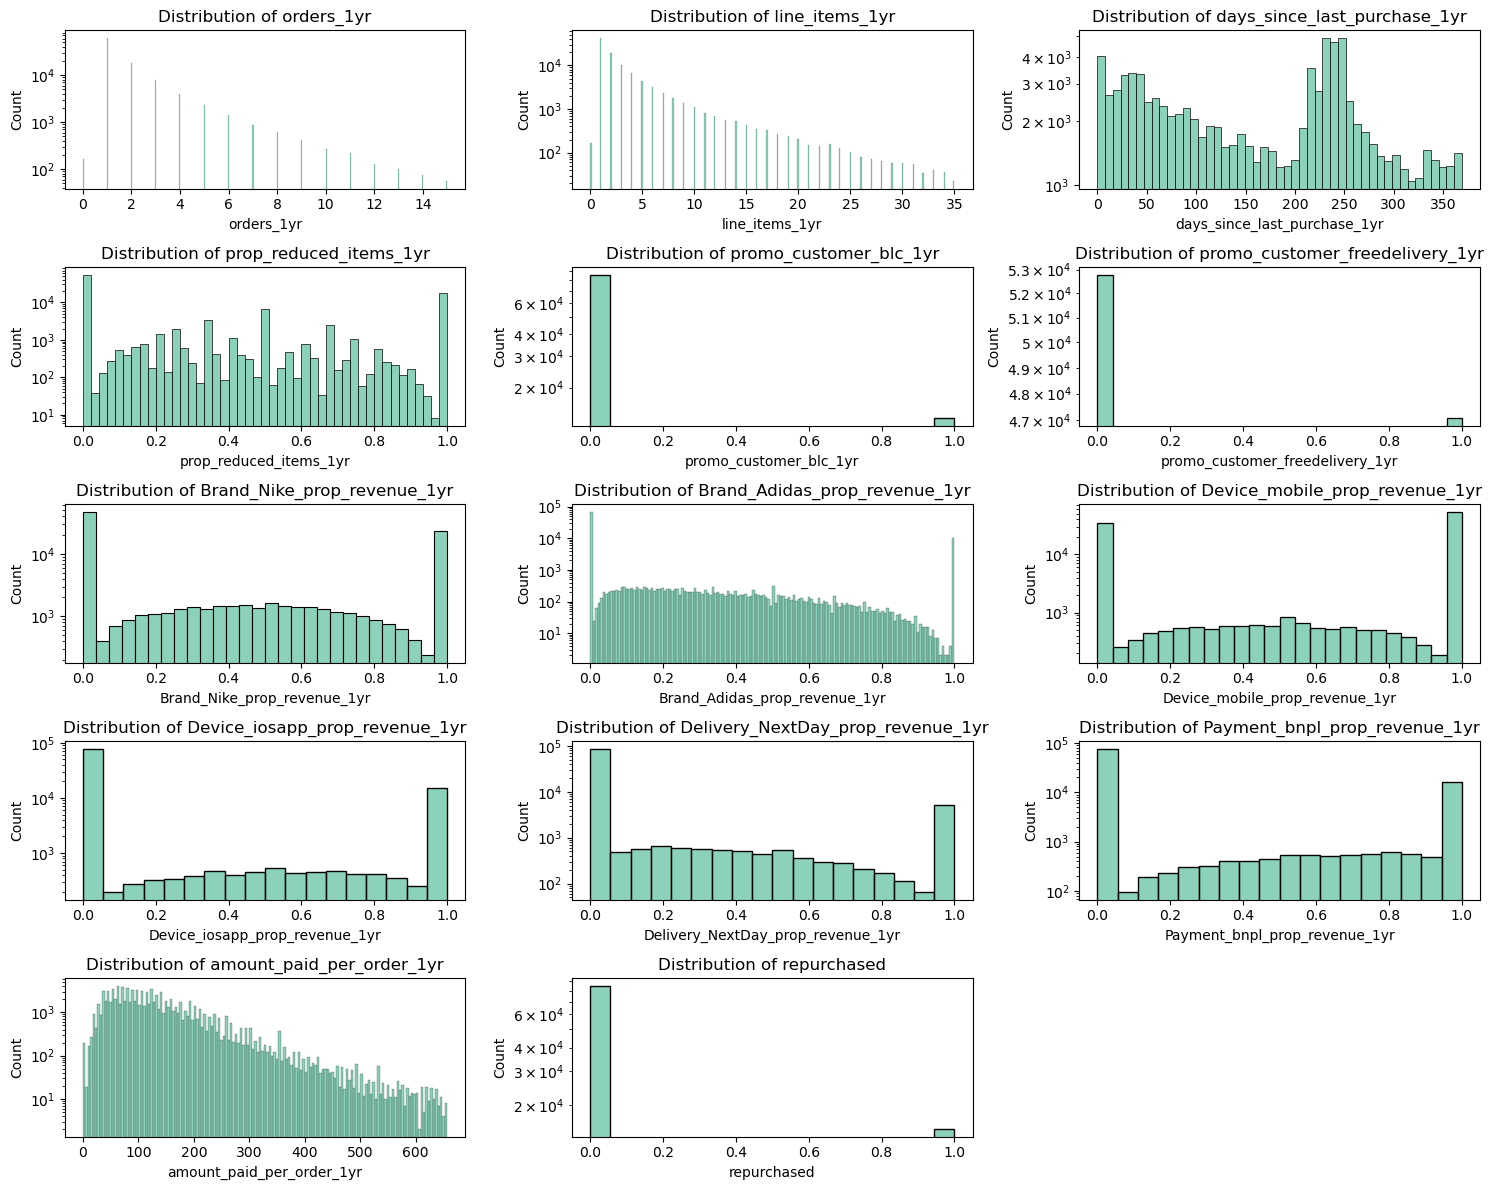

In [3]:
dfc = df.drop(columns=['customer_site_id','Current_RFM_Segment','ONS_Segment']).dropna()
#dfc.describe()
#dfc = pd.get_dummies(dfc, drop_first=True) 
dfc = dfc[(np.abs(stats.zscore(dfc)) < 5).all(axis=1)]
numeric_cols = dfc.select_dtypes(include=['float64', 'int64']).columns

# Check the shape of the cleaned dataset
print(dfc.shape)

sns.set_palette("Set2") 
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols)//3 + 1, 3, i)
    ax = sns.histplot(dfc[col], kde=False)
    plt.title(f'Distribution of {col}')
    # Set the y-axis to logarithmic scale
    ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# Target variable (repurchase likelihood)
target = dfc['repurchased']  # Binary target variable (1 = repurchased, 0 = no repurchase)

def make_XY(variables):
    assert isinstance(variables, list)
    df_cut = dfc[variables]
    
    # Splitting the data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(df_cut, target, test_size=0.2, random_state=0, shuffle=True, stratify=target)
    return X_train, X_test, y_train, y_test

#### combining the corelated variables (or so called feature engineering) to avoid multicolinearity 
#### while classification model try to train on the data.
#### Decided to do the simple submission and not multiplication as they are most -ve corelated.
dfc['promo_combined']= dfc['promo_customer_freedelivery_1yr']+dfc['promo_customer_blc_1yr']
dfc['Brand_combined']= dfc['Brand_Adidas_prop_revenue_1yr']+dfc['Brand_Nike_prop_revenue_1yr']
dfc['Device_combined'] = dfc['Device_mobile_prop_revenue_1yr']+dfc['Device_iosapp_prop_revenue_1yr']

X_train, X_test, y_train, y_test = make_XY([
    'orders_1yr',
    'promo_combined', 
    'Brand_combined',
    'Device_combined',
    'Payment_bnpl_prop_revenue_1yr'
])

In [5]:
### checking class imbalance
from sklearn.utils import shuffle
#unique, counts = np.unique(y_train, return_counts=True)
#print(dict(zip(unique, counts)))
#### balancing the class imbalance in output
#from imblearn.under_sampling import RandomUnderSampler
# Apply undersampling
#undersampler = RandomUnderSampler(random_state=42)
#X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

#### Check the new class distribution
#unique, counts = np.unique(y_train_resampled, return_counts=True)
#print(dict(zip(unique, counts)))


#### Class balancing
#from sklearn.utils import class_weight
# Compute class weights
#unique_classes = np.unique(y_train)
#print(f"Unique Classes in y_train: {unique_classes}")

#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weights_dict = dict(enumerate(class_weights))
#print(f"Class Weights Dictionary: {class_weights_dict}")

# Assuming X_train and y_train are your features and labels
X_train = pd.DataFrame(X_train)  # Convert to DataFrame for easy manipulation
y_train = pd.Series(y_train)  # Convert to Series for easy manipulation

# Separate majority and minority classes
minority_class = X_train[y_train == 1]  # All samples from the minority class (label = 1)
majority_class = X_train[y_train == 0]  # All samples from the majority class (label = 0)

# Get the number of minority samples
n_minority = len(minority_class)

# Randomly sample from the majority class to match the minority class size
majority_class_downsampled = majority_class.sample(n=n_minority, random_state=42)

# Combine the downsampled majority class with the minority class
X_train_balanced = pd.concat([minority_class, majority_class_downsampled])
y_train_balanced = pd.concat([y_train[y_train == 1], y_train[y_train == 0].sample(n=n_minority, random_state=42)])

# Shuffle the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

# Convert back to NumPy arrays for Keras compatibility
X_train_balanced = X_train_balanced.to_numpy()
y_train_balanced = y_train_balanced.to_numpy()

unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))


{0: 11866, 1: 11866}


In [6]:
#### Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [7]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

2024-09-25 22:22:39.346707: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def make_model(x,layers,neurons,lr):
    inputs = keras.Input(shape=(x.shape[1],))
    hidden_layer = keras.layers.Dense(neurons, activation="relu")(inputs)
    for _ in range(layers-1):
        hidden_layer = keras.layers.Dense(neurons, activation="relu")(hidden_layer)
    output_layer = keras.layers.Dense(1, activation="sigmoid")(hidden_layer)
    model = keras.Model(inputs=inputs, outputs=output_layer)
    opt = keras.optimizers.Adam(learning_rate=lr) 
    loss = keras.losses.BinaryCrossentropy() 
    metric =['accuracy']
    model.compile(optimizer=opt, loss=loss, metrics=metric)
    return model


In [9]:
model = make_model(X_train_scaled,layers=3,neurons=64, lr=0.00001)
#model.summary()

#### Adding Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitors the validation loss
    patience=5,            # Number of epochs to wait after no improvement
    restore_best_weights=True  # Restores the weights of the best epoch
)

In [10]:
history = model.fit(X_train_scaled, 
                    y_train_balanced, 
                    validation_data=(X_test_scaled,y_test),
                    epochs=75,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5015 - loss: 0.7001 - val_accuracy: 0.8033 - val_loss: 0.6354
Epoch 2/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6227 - loss: 0.6741 - val_accuracy: 0.7547 - val_loss: 0.6311
Epoch 3/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6491 - loss: 0.6543 - val_accuracy: 0.7208 - val_loss: 0.6265
Epoch 4/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6524 - loss: 0.6382 - val_accuracy: 0.7147 - val_loss: 0.6220
Epoch 5/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6542 - loss: 0.6276 - val_accuracy: 0.7148 - val_loss: 0.6167
Epoch 6/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6548 - loss: 0.6214 - val_accuracy: 0.7153 - val_loss: 0.6125
Epoch 7/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6557 - loss: 0.6178 - val_accuracy: 0.7163 - val_loss: 0.6097
Epoch 8/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6570 - loss: 0.6155 - val_accuracy: 0.

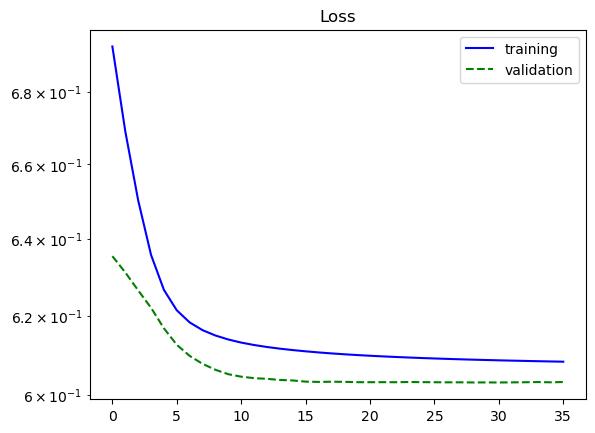

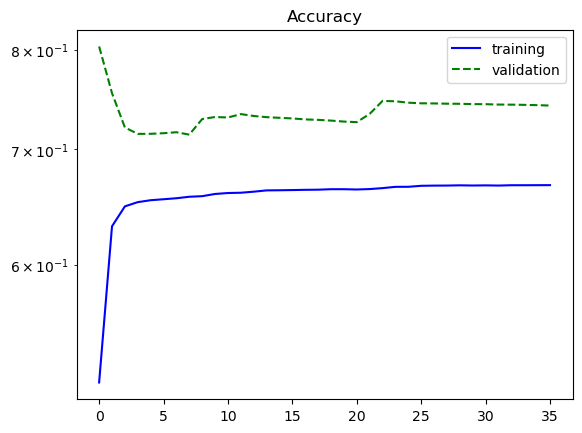

In [11]:
sns.lineplot(x=history.epoch, y=history.history['loss'],color='b',label='training')
sns.lineplot(x=history.epoch, y=history.history['val_loss'],color='g',linestyle='--',label='validation')
plt.yscale('log')
plt.title('Loss')
plt.show()

sns.lineplot(x=history.epoch, y=history.history['accuracy'],color='b',label='training')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'],color='g',linestyle='--',label='validation')
plt.yscale('log')
plt.title('Accuracy')
plt.show()


In [12]:
#### Save the model
model.save('trained_model1.keras')

742/742 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


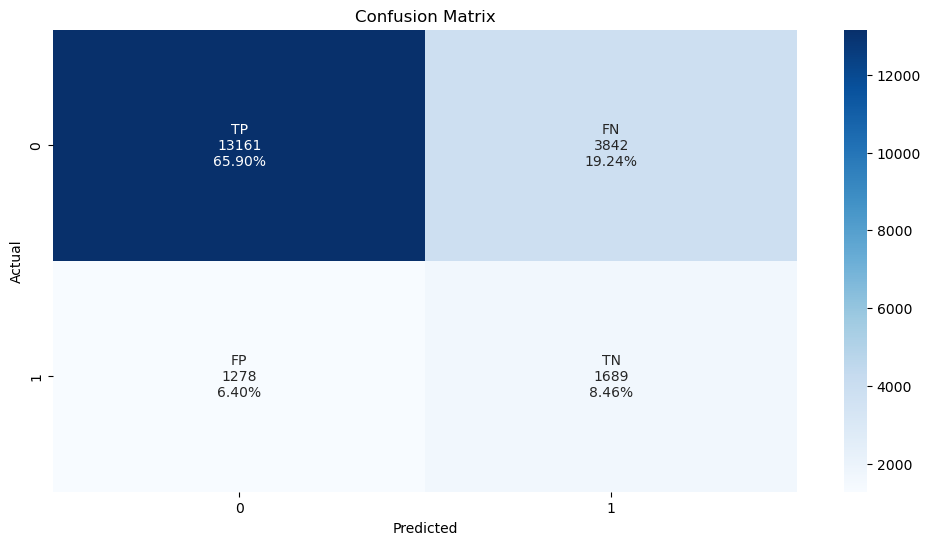

Total Accuracy: 0.74
In a test sample of size 19970
This Model will send total emails : 5531
Where Estimated misclassification cost (in Pounds) is : 7684.00


In [13]:
# Load the saved model
loaded_model = keras.models.load_model('trained_model1.keras')
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Make predictions on the train and test sets
y_train_pred = loaded_model.predict(X_train_scaled).ravel()  # Predict probabilities for training set
y_test_pred = loaded_model.predict(X_test_scaled).ravel()    # Predict probabilities for test set

#### Convert predicted probabilities to class labels (0 or 1)
y_pred = np.round(y_test_pred).astype(int)  # For binary classification


# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
#print(f"Confusion Matrix:\n{cf_matrix}")

plt.figure(figsize=(12,6))
group_names = ['TP','FN','FP','TN']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
#print(f"Confusion Matrix:\n{conf_matrix_normalized}")
#sns.heatmap(conf_matrix_normalized , annot=True,   fmt='g', cmap='YlGnBu', linewidths=0.5, vmin=np.min(conf_matrix_normalized), vmax=np.max(conf_matrix_normalized))

plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 0: when customer doesnt repurchase, 1 : when customer repurchases 
## TP : "when customer doesn't make a purchase and has been predicted so (0,0)"
## FN : "when customer actually made no purchase but model predicted he did (0,1)"
## FP : "when customer actually made a purchase but model predicted he didn't (1,0)"
## TN :  "when customer actually made a purchase but model predicted he did (1,1)"

# Extract values from the confusion matrix
TP, FN, FP, TN = cf_matrix.ravel()
#print("TP: ", TP, " FN: ", FN, "\nFP: ", FP, " TN: ",TN)

#### Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Total Accuracy: {accuracy:.2f}")


#### Calculate Misclassification Rate
#misclassification_rate = (FP + FN) / (TP + TN + FP + FN)
#print(f"Total Misclassification Rate: {misclassification_rate:.2f}")

print("In a test sample of size", len(y_test))
#### The customers that this model will send emails to is where model predicts 1, which will be total of FN and TN.
print(f"This Model will send total emails : {(FN+TN):d}") 

#### Calculate Misclassification Cost sent per email 
#### To look at this, we need to know how many times my model predicted that customer would repurchase but in reality he wont (This is FN)
CostPerEmail = 2 
misclassification_cost = (FN) * CostPerEmail
print(f"Where Estimated misclassification cost (in Pounds) is : {misclassification_cost:.2f}")

#### Calculate FP Rate
#False_Positive_rate = (FP)/ (TN + FP)
#print(f"FPR : {False_Positive_rate:.2f}")

#### Calculate TP Rate/Recall (Of all the actual positives, how many did the model correctly identify?")
#True_Positive_rate = (TP)/ (TP + FN)
#print(f"TPR/Recall : {True_Positive_rate:.2f}")


#### Precision :  "When the model predicts positive, how often is it corr" OR How many of the predicted positives were actually correct?
#Precision = TP/(TP+FP)
#print(f"Precision : {Precision:.2f}")

#### F1-score: harmonic mean of precision and recall (A balanced measure of precision and recall. Useful when you need a balance between the two.)
#F1_score = 2*Precision*True_Positive_rate/(Precision+True_Positive_rate)
#print(f"F1 Score : {F1_score:.2f}")

In [14]:
#from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for training set
#fpr_train, tpr_train, _ = roc_curve(y_train_balanced, y_train_pred)
#roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and ROC area for test set
#fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
#roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC curves
#plt.figure(figsize=(10, 6))

#sns.lineplot(x=fpr_train, y=tpr_train, color='b', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.3f})')

# Plot ROC curve for the testing set
#sns.lineplot(x=fpr_test, y=tpr_test, color='r', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.3f})')

# Plot the random guessing diagonal line
#sns.lineplot(x=[0, 1], y=[0, 1], color='black', linestyle='--')

#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
#plt.legend(loc='lower right')
#plt.grid(True)
#plt.show()

#### Various configurations that gave sensible result once learning rate was 0.00001
##### In format of (number of hidden layers/neurons in all layers/acc test) - AUC
##### 4,64  - 72.5% (accuracy plot is okayish, loss fun looks too good)
##### 3,64  - 72.5% (goody)
### 2,64  - 72.4% (also goody)
##### 1,64 -  65% (NO)
##### 2,128 - 72.5% (accuracy plot is not smooth, loss fun looks too good)
##### 3,128 - 72.5% (accuracy plot is not smooth, loss fun looks too good)
##### 4,32  - 72.4% (NO accurancy plots is too bad)
##### 3, 32 - 72.3% (NO accurancy plots is still ehhhhh)
##### 2, 32 - 72.4% (okayish!!)

# Key Insights from DNN Binary Classification modelling
- Started with input features that gave good results with logestic regression model.
- For pre-processing used same caveats of removing outliers/scaling.
- Here for class imbalance, the technique of using class-weights as I did in regression model or using undersampler didnt work, so undersampled the imbalance using python only.  
- Took several iterations to find "goodish" model using keras where there is no bias when we look at how loss function behaves as a function of epochs on test data.  Accuracy is not smooth but probably adding more ways to avoid overfitting can help. 
- Here, to deal with regularization, added early stopping in the model. 
- But overall, here the accuracy is 74% (74%) where in misidentification cost is slightly better 7684(7752) pounds (compared to logestic regession model without gridSerachCV algo where fit failed.)
|Model Architecture  | |
|-----|:----- | 
| Neurons | 64 | 
| Layers  | 3 | 
| Optimizer | Adam | 
| Loss Function| BinaryCrossentropy | 
| Activation Function| Relu/Sigmoid | 
| Learning Rate| 0.00001 |  
- Next is to see the effects of adding Batch normarmalization/DropOuts, if they make any impact here!

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization

def build_dnn(input_dim,hiddenlayers,neurons,lr):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    for _ in range(hiddenlayers):
        model.add(Dense(neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))    
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary
    opt = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.BinaryCrossentropy()
    metric =['accuracy']
    model.compile(optimizer=opt, loss=loss, metrics=metric)
    return model

In [33]:
#### Make the model 
input_dim = X_train_scaled.shape[1]  # Number of input features
model = build_dnn(input_dim,3,32,0.00001)
#### Adding Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitors the validation loss
    patience=5,            # Number of epochs to wait after no improvement
    restore_best_weights=True  # Restores the weights of the best epoch
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
#### fit the model
history = model.fit(
    X_train_scaled, 
    y_train_balanced,
    epochs=75,                   # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping]    # Add early stopping to the training
)


Epoch 1/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4957 - loss: 0.9715 - val_accuracy: 0.5888 - val_loss: 0.6865
Epoch 2/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5171 - loss: 0.9161 - val_accuracy: 0.6583 - val_loss: 0.6354
Epoch 3/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5341 - loss: 0.8538 - val_accuracy: 0.6618 - val_loss: 0.6158
Epoch 4/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5422 - loss: 0.8169 - val_accuracy: 0.6962 - val_loss: 0.5898
Epoch 5/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5541 - loss: 0.8057 - val_accuracy: 0.7384 - val_loss: 0.5844
Epoch 6/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5559 - loss: 0.7858 - val_accuracy: 0.7661 - val_loss: 0.5797
Epoch 7/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5690 - loss: 0.7692 - val_accuracy: 0.7678 - val_loss: 0.5742
Epoch 8/75
742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5665 - loss: 0.7587 - val_accuracy: 0.

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7778 - loss: 0.5648
Test Loss: 0.56589674949646, Test Accuracy: 0.779869794845581


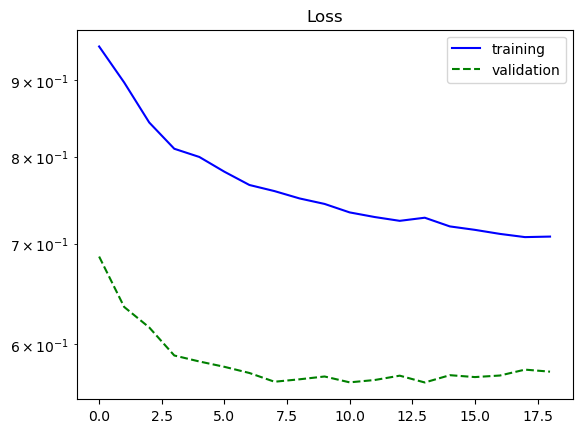

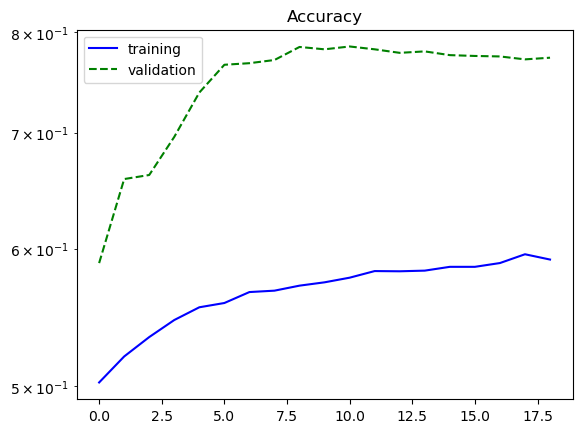

In [35]:
#### Evaluate the model 
score = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')
 
import matplotlib.pyplot as plt

sns.lineplot(x=history.epoch, y=history.history['loss'],color='b',label='training')
sns.lineplot(x=history.epoch, y=history.history['val_loss'],color='g',linestyle='--',label='validation')
plt.title('Loss')
plt.yscale('log')
plt.show()

sns.lineplot(x=history.epoch, y=history.history['accuracy'],color='b',label='training')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'],color='g',linestyle='--',label='validation')
plt.title('Accuracy')
plt.yscale('log')
plt.show()

In [36]:
#### Save the model
model.save('trained_model2.keras')

742/742 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


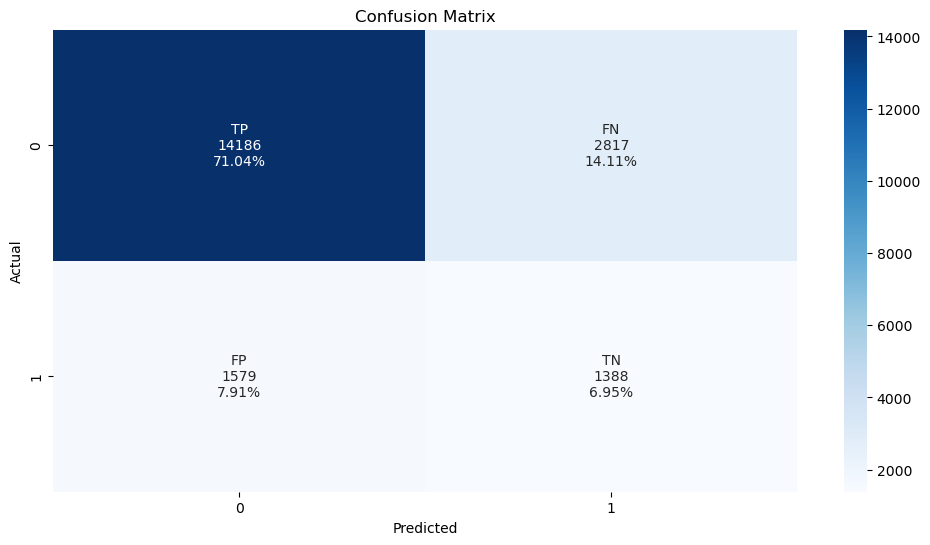

Total Accuracy: 0.78
In a test sample of size 19970
This Model will send total emails : 4205
Where Estimated misclassification cost (in Pounds) is : 5634.00


In [37]:
# Load the saved model
loaded_model = tf.keras.models.load_model('trained_model2.keras')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
# Make predictions on the train and test sets
y_train_pred = loaded_model.predict(X_train_scaled).ravel()  # Predict probabilities for training set
y_test_pred = loaded_model.predict(X_test_scaled).ravel()    # Predict probabilities for test set

#### Convert predicted probabilities to class labels (0 or 1)
y_pred = np.round(y_test_pred).astype(int)  # For binary classification


# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
#print(f"Confusion Matrix:\n{cf_matrix}")

plt.figure(figsize=(12,6))
group_names = ['TP','FN','FP','TN']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
#print(f"Confusion Matrix:\n{conf_matrix_normalized}")
#sns.heatmap(conf_matrix_normalized , annot=True,   fmt='g', cmap='YlGnBu', linewidths=0.5, vmin=np.min(conf_matrix_normalized), vmax=np.max(conf_matrix_normalized))

plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 0: when customer doesnt repurchase, 1 : when customer repurchases 
## TP : "when customer doesn't make a purchase and has been predicted so (0,0)"
## FN : "when customer actually made no purchase but model predicted he did (0,1)"
## FP : "when customer actually made a purchase but model predicted he didn't (1,0)"
## TN :  "when customer actually made a purchase but model predicted he did (1,1)"

# Extract values from the confusion matrix
TP, FN, FP, TN = cf_matrix.ravel()
#print("TP: ", TP, " FN: ", FN, "\nFP: ", FP, " TN: ",TN)

#### Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Total Accuracy: {accuracy:.2f}")


#### Calculate Misclassification Rate
#misclassification_rate = (FP + FN) / (TP + TN + FP + FN)
#print(f"Total Misclassification Rate: {misclassification_rate:.2f}")

print("In a test sample of size", len(y_test))
#### The customers that this model will send emails to is where model predicts 1, which will be total of FN and TN.
print(f"This Model will send total emails : {(FN+TN):d}") 

#### Calculate Misclassification Cost sent per email 
#### To look at this, we need to know how many times my model predicted that customer would repurchase but in reality he wont (This is FN)
CostPerEmail = 2 
misclassification_cost = (FN) * CostPerEmail
print(f"Where Estimated misclassification cost (in Pounds) is : {misclassification_cost:.2f}")

#### Calculate FP Rate
#False_Positive_rate = (FP)/ (TN + FP)
#print(f"FPR : {False_Positive_rate:.2f}")

#### Calculate TP Rate/Recall (Of all the actual positives, how many did the model correctly identify?")
#True_Positive_rate = (TP)/ (TP + FN)
#print(f"TPR/Recall : {True_Positive_rate:.2f}")


#### Precision :  "When the model predicts positive, how often is it corr" OR How many of the predicted positives were actually correct?
#Precision = TP/(TP+FP)
#print(f"Precision : {Precision:.2f}")

#### F1-score: harmonic mean of precision and recall (A balanced measure of precision and recall. Useful when you need a balance between the two.)
#F1_score = 2*Precision*True_Positive_rate/(Precision+True_Positive_rate)
#print(f"F1 Score : {F1_score:.2f}")

# Key Insights from DNN Binary Classification modelling with BatchNormalization and DropOuts implemented
- Implemented the model again and look several iterations to find better model using sequential model.  
- Here, to deal with regularization, added Batch Normalization and dropout after each layer in the model. 
- But overall, here the accuracy is slightly better 78% (74%) where in misidentification cost is better 5634 (7684) pounds (compared to without BN and DO techniques incorporated).

|Model Architecture  | |
|-----|:----- | 
| Neurons | 64 For Input Layer (32 for Hidden layers) | 
| Layers  | 3 | 
| Optimizer | Adam | 
| Loss Function| BinaryCrossentropy | 
| Activation Function| Relu/Sigmoid | 
| Learning Rate| 0.00001 |

- Now to see the impact of categorical variables during the training, making another notebook JDModel_WOHE.ipynb.